In [6]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
%pip install sentence-transformers
%pip install langchain-community

Looking in indexes: https://download.pytorch.org/whl/cu126
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  Using cached httpx_sse-0.4.0-py3-none-any.whl.metadata (9.0 kB)
  Using cached aiosignal-1.3.2-py2.py3-none-any.whl.metadata (3.8 kB)
  Using cached frozenlist-1.5.0-cp312-cp312-win_amd64.whl.metadata (14 kB)
  Using cached yarl-1.18.3-cp312-cp312-win_amd64.whl.metadata (71 kB)
  Using cached marshmallow-3.26.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached typing_inspect-0.9.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
  Using cached mypy_extensions-1.0.0-py3-none-any.whl.metadata (1.1 kB)
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------------------------------- 2.5/2.5 MB 18.1 MB/s eta 0:00:00
Using cached dataclasses_json-0.6.7-py3-none-any.whl (28 kB)
Using cached httpx_sse-0.4.0-py3-none-any.whl (7.8 kB)
Using cached aiosignal-1.3.2-py2.py3-none-any.whl (7.6 kB)
Using cached frozenlist-1.5.0-cp312-cp312-win


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from glob import glob

for g in glob('./data/*.pdf'):
    print(g)

./data\2040_seoul_plan.pdf
./data\OneNYC_2050_Strategic_Plan.pdf


In [7]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

def read_pdf_and_split_text(pdf_path, chunk_size=1000, chunk_overlap=100):
    """
    주어진 PDF 파일을 읽고 텍스트를 분할합니다.
    매개변수:
        pdf_path (str): PDF 파일의 경로.
        chunk_size (int, 선택적): 각 텍스트 청크의 크기. 기본값은 1000입니다.
        chunk_overlap (int, 선택적): 청크 간의 중첩 크기. 기본값은 100입니다.
    반환값:
        list: 분할된 텍스트 청크의 리스트.
    """
    print(f"PDF: {pdf_path} -----------------------------")

    pdf_loader = PyPDFLoader(pdf_path)
    data_from_pdf = pdf_loader.load()

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap
    )

    splits = text_splitter.split_documents(data_from_pdf)
    
    print(f"Number of splits: {len(splits)}\n")
    return splits


In [8]:
from langchain_community.embeddings import HuggingFaceBgeEmbeddings

model_name = "BAAI/bge-m3"
model_kwargs = {"device": "cuda"}
encode_kwargs = {"normalize_embeddings": True}
hf = HuggingFaceBgeEmbeddings(
    model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)

C:\Users\saint\AppData\Local\Temp\ipykernel_26308\1886202769.py:6: LangChainDeprecationWarning: The class `HuggingFaceBgeEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  hf = HuggingFaceBgeEmbeddings(
c:\github\lab_langgraprh_101\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
%pip install langchain_chroma
%pip install pypdf

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import os
from langchain_chroma import Chroma

persist_directory='./chroma_store'

if os.path.exists(persist_directory):
    print("Loading existing Chroma store")
    vectorstore = Chroma(
        persist_directory=persist_directory, 
        embedding_function=hf
    )
else:
    print("Creating new Chroma store")
    
    vectorstore = None
    for g in glob('./data/*.pdf'):
        chunks = read_pdf_and_split_text(g)
        # 100개씩 나눠서 저장
        for i in range(0, len(chunks), 100):
            if vectorstore is None:
                vectorstore = Chroma.from_documents(
                    documents=chunks[i:i+100],
                    embedding=hf,
                    persist_directory=persist_directory
                )
            else:
                vectorstore.add_documents(
                    documents=chunks[i:i+100]
                )

Creating new Chroma store
PDF: ./data\2040_seoul_plan.pdf -----------------------------
Number of splits: 308

PDF: ./data\OneNYC_2050_Strategic_Plan.pdf -----------------------------
Number of splits: 1023



## 리트리버가 잘 작동하는지 테스트

In [14]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

chunks = retriever.invoke("서울 온실가스 저감 계획")

for chunk in chunks:
    print(chunk.metadata)
    print(chunk.page_content)

{'author': 'SI', 'creationdate': '2024-12-12T18:16:11+09:00', 'creator': 'Hwp 2020 11.0.0.5178', 'moddate': '2024-12-12T18:16:11+09:00', 'page': 45, 'page_label': '46', 'pdfversion': '1.4', 'producer': 'Hancom PDF 1.3.0.542', 'source': './data\\2040_seoul_plan.pdf', 'total_pages': 205}
기후변화에 대응하기 위한 온실가스 적극 감축 및 녹색 인프라 확충 등을 강조하고 있다.Ÿ2040 서울도시기본계획의 부문별 전략계획과 공간계획에서는 서울의 글로벌 경쟁력 강화, 광역화에 따른 수도권 내 교통, 산업 등 네트워크 연계 강화, 기후위기에 대응하기 위한 지속가능한 서울로의 전환 등 수도권정비기본계획의 주요 내용을 적극적으로 반영하여 수립하였다.
{'author': 'SI', 'creationdate': '2024-12-12T18:16:11+09:00', 'creator': 'Hwp 2020 11.0.0.5178', 'moddate': '2024-12-12T18:16:11+09:00', 'page': 187, 'page_label': '188', 'pdfversion': '1.4', 'producer': 'Hancom PDF 1.3.0.542', 'source': './data\\2040_seoul_plan.pdf', 'total_pages': 205}
180제6장 계획의 실현
부문지표명지표의 통계명내용 및 산정식출처목표치 및 관리방향
기후·환경
탄소중립온실가스 배출량건물·수송·폐기물 처리 등에 따른 서울의 온실가스 배출량서울시 내부자료(기후환경정책과)2005년 대비 70% 감축대기질개선초미세먼지 농도*서울시 대기 중 2.5㎛보다 작은 초미세먼지의 농도서울특별시 대기환경정보10㎍/㎥(2040)신재생에너지신재생에너지 보급률*서울시 총 에너지보급량 중 

## 언어모델 불러오기

In [15]:
from langchain_openai import ChatOpenAI

# 모델 초기화
model = ChatOpenAI(model="gpt-4o-mini")
model.invoke('안녕하세요!')

AIMessage(content='안녕하세요! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 10, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'id': 'chatcmpl-BDtvqZFrzOfM8OTL99D4YhRyrDsJe', 'finish_reason': 'stop', 'logprobs': None}, id='run-722426db-61a0-45e8-b663-71f3df24b941-0', usage_metadata={'input_tokens': 10, 'output_tokens': 11, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

## 단순한 대화가 필요할 때와 RAG 필요할 때 구분하기

In [16]:
# Router 설정
from langchain_core.prompts import ChatPromptTemplate
from typing import Literal # 문자열 리터럴 타입을 지원하는 typing 모듈의 클래스
from pydantic import BaseModel, Field

# Data model
class RouteQuery(BaseModel):
    """사용자 쿼리를 가장 관련성이 높은 데이터 소스로 라우팅합니다."""
    
    datasource: Literal["vectorstore", "casual_talk"] = Field(
        ...,
        description="""
        사용자 질문에 따라 casual_talk 또는 vectorstore로 라우팅합니다.
        - casual_talk: 일상 대화를 위한 데이터 소스. 사용자가 일상적인 질문을 할 때 사용합니다.
        - vectorstore: 사용자 질문에 답하기 위해 RAG로 vectorstore 검색이 필요한 경우 사용합니다.
        """,
    )

In [17]:
# 특정 모델을 structured output (구조화된 출력)과 함께 사용하기 위해 설정
structured_llm_router = model.with_structured_output(RouteQuery)

router_system = """
당신은 사용자의 질문을 vectorstore 또는 casual_talk으로 라우팅하는 전문가입니다.
- vectorstore에는 서울, 뉴욕의 발전계획과 관련된 문서가 포함되어 있습니다. 이 주제에 대한 질문에는 vectorstore를 사용하십시오.
- 사용자의 질문이 일상 대화에 관련된 경우 casual_talk을 사용하십시오.
"""

# 시스템 메시지와 사용자의 질문을 포함하는 프롬프트 템플릿 생성
route_prompt = ChatPromptTemplate.from_messages([
    ("system", router_system),
    ("human", "{question}"),
])

# 라우터 프롬프트와 구조화된 출력 모델을 결합한 객체
question_router = route_prompt | structured_llm_router

In [18]:
print(
    question_router.invoke({
        "question": "서울 온실가스 저감 계획은 무엇인가요?"
    })
)

print(question_router.invoke({"question": "잘 지냈어?"}))

datasource='vectorstore'
datasource='casual_talk'


## RAG 사용시, retriever가 가져온 자료 중 쓸모 있는 자료만 활용하기
- 토큰 절약
- 답변 퀄리티 향상

In [19]:
from langchain_core.prompts import PromptTemplate

class GradeDocuments(BaseModel):
    """검색된 문서가 질문과 관련성 있는지 yes 또는 no로 평가합니다."""

    binary_score: Literal["yes", "no"] = Field(
        description="문서가 질문과 관련이 있는지 여부를 'yes' 또는 'no'로 평가합니다."
    )

structured_llm_grader = model.with_structured_output(GradeDocuments)

In [22]:
grader_prompt = PromptTemplate.from_template("""
당신은 검색된 문서가 사용자 질문과 관련이 있는지 평가하는 평가자입니다. \n 
문서에 사용자 질문과 관련된 키워드 또는 의미가 포함되어 있으면, 해당 문서를 관련성이 있다고 평가하십시오. \n
엄격한 테스트가 필요하지 않습니다. 목표는 잘못된 검색 결과를 걸러내는 것입니다. \n
문서가 질문과 관련이 있는지 여부를 나타내기 위해 'yes' 또는 'no'로 이진 점수를 부여하십시오.
                                             
Retrieved document: \n {document} \n\n 
User question: {question}
""")

retrieval_grader = grader_prompt | structured_llm_grader
question = "서울시 온실가스 관련 계획"
documents = retriever.invoke(question)

for doc in documents:
    print(doc)


page_content='180제6장 계획의 실현
부문지표명지표의 통계명내용 및 산정식출처목표치 및 관리방향
기후·환경
탄소중립온실가스 배출량건물·수송·폐기물 처리 등에 따른 서울의 온실가스 배출량서울시 내부자료(기후환경정책과)2005년 대비 70% 감축대기질개선초미세먼지 농도*서울시 대기 중 2.5㎛보다 작은 초미세먼지의 농도서울특별시 대기환경정보10㎍/㎥(2040)신재생에너지신재생에너지 보급률*서울시 총 에너지보급량 중 신·재생에너지 보급 비율한국에너지공단21%(2030)탄소배출감축건물 에너지 효율화 사업 수에너지다소비건물, 공공건물, 상업건물, 주택 등에 대한 건물에너지효율화 사업 개소수(누적) 서울시 내부자료(친환경건물과)100만 호(2026)자원순환인구당 생활폐기물 발생량(매립률)서울시민 1인당 하루 평균 생활폐기물 배출량(서울 하루 평균 생활폐기물 배출량/인구 수)과 생활폐기물 중 매립되는 비율 서울통계0.86㎏/인/일(2027)물순환물재이용량*빗물, 중수도시설, 하수처리수로 대체하여 이용한 물의 양서울시 내부자료(수변감성도시과)증가녹지환경만족녹지환경만족도시민이 현재 거주하는 지역의 녹지환경(공원, 숲 등)에 대하여 만족하는 정도서울서베이증가공원확충1인당 공원면적*공원 면적(도시자연공원구역+도시계획시설 공원+국립공원)/인구수서울시 공원통계증가수변공간활성화한강공원 이용객수산책, 낚시, 자전거, 인라인, 운동·수상시설, 수영장, 행사 등을 위하여 한강공원을 이용한 이용객 수서울시 통계정보시스템증가
안전·방재' metadata={'author': 'SI', 'creationdate': '2024-12-12T18:16:11+09:00', 'creator': 'Hwp 2020 11.0.0.5178', 'moddate': '2024-12-12T18:16:11+09:00', 'page': 187, 'page_label': '188', 'pdfversion': '1.4', 'producer': 'Hancom PDF 1.3.0.542', 'source': './da

In [23]:
filtered_docs = []

for i, doc in enumerate(documents):
    print(f"Document {i + 1}:")
    is_relevant = retrieval_grader.invoke({"question": question, "document": doc.page_content})
    print(is_relevant)
    print(doc.page_content[:200])
    print("=================================\n\n")

    if is_relevant.binary_score == "yes":
        filtered_docs.append(doc)

print(f"Filtered documents: {len(filtered_docs)}")


Document 1:
binary_score='yes'
180제6장 계획의 실현
부문지표명지표의 통계명내용 및 산정식출처목표치 및 관리방향
기후·환경
탄소중립온실가스 배출량건물·수송·폐기물 처리 등에 따른 서울의 온실가스 배출량서울시 내부자료(기후환경정책과)2005년 대비 70% 감축대기질개선초미세먼지 농도*서울시 대기 중 2.5㎛보다 작은 초미세먼지의 농도서울특별시 대기환경정보10㎍/㎥(2040)신재생에너지신


Document 2:
binary_score='yes'
기후변화에 대응하기 위한 온실가스 적극 감축 및 녹색 인프라 확충 등을 강조하고 있다.Ÿ2040 서울도시기본계획의 부문별 전략계획과 공간계획에서는 서울의 글로벌 경쟁력 강화, 광역화에 따른 수도권 내 교통, 산업 등 네트워크 연계 강화, 기후위기에 대응하기 위한 지속가능한 서울로의 전환 등 수도권정비기본계획의 주요 내용을 적극적으로 반영하여 수립하였다.


Document 3:
binary_score='yes'
제3절 2040 서울도시기본계획 7대 목표57Ÿ특히, 서울시는 현재 온실가스 배출량의 90%를 차지하고 있는 건물과 수송 부문 감축을 위해 적극적인 대책을 마련하고 있다.-2026년까지 건물 에너지효율화사업 100만 호를 추진, 건물온실가스총량제, 신규건물 제로에너지 건물(ZEB) 의무화를 통해 기존 및 신규건물의 제로에너지화를 촉진-수송 부문 배출감축을 


Document 4:
binary_score='no'
2-7] 서울시민 의견 조사 개요············································································································40[표 2-8] 서울시민 의견 조사 내용···················································


Document 5:
binary_score='no'
[그림 2-17] 서울시 인구추계(2010-2040)자료: KOSI

In [25]:
### Generate
# PromptTemplate을 사용하여 RAG를 위한 프롬프트를 생성합니다.

rag_generate_system = """
너는 사용자의 질문에 대해 주어진 context에 기반하여 답변하는 도시 계획 전문가이다. 
주어진 context는 vectorstore에서 검색된 결과이다. 
주어진 context를 기반으로 사용자의 question에 대해 답변하라.

=================================
question: {question}
context: {context}
"""

# PromptTemplate을 생성하여 question과 context를 포맷팅
rag_prompt = PromptTemplate(
    input_variables=["question", "context"],
    template=rag_generate_system
)

# rag chain
rag_chain = rag_prompt | model 

# 사용자 질문과 검색된 문서를 입력으로 사용하여 RAG를 실행
question = "서울시 온실가스 관련 계획"

rag_chain.invoke({"question": question, "context": filtered_docs})


AIMessage(content="서울시는 온실가스 감축과 기후변화 대응을 위한 다양한 계획을 마련하고 있습니다. 특히, 현재 온실가스 배출의 90%를 차지하고 있는 건물 및 수송 부문에 대한 적극적인 대책이 진행 중입니다. 2026년까지 100만 호의 건물 에너지 효율화 사업을 추진하고, 신규 건물에 대해 제로에너지 건물(ZEB) 의무화를 통해 기존 및 신규 건물의 제로에너지화 촉진을 목표로 하고 있습니다.\n\n또한, 수송 부문에서는 전기차 비중을 2026년까지 10%로 확대하고, 22만 개의 충전 인프라를 구축할 예정입니다. 이러한 계획들은 시민 생활과 안전을 보장하기 위한 기후위기 대응 전략의 일환으로, 기후재해로부터 시민을 보호하고 도시의 회복력을 강화하기 위해 필요합니다.\n\n서울시는 온실가스 감축 방법을 모든 예산 사업에 반영하기 위해 2021년부터 '기후예산제'를 시범 운영하고 있으며, 이와 함께 도시 계획 단계에서도 탄소중립과 기후위기 적응 대책을 반영할 방침입니다. 이러한 종합적인 접근을 통해 서울시는 지속 가능한 도시로의 전환을 지향하고 있습니다.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 294, 'prompt_tokens': 1827, 'total_tokens': 2121, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'id': 'chatcmpl-BDtz

## State

In [26]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    question: str   # 사용자 질문
    generation: str # LLM 생성 결과
    documents: List[str] # 검색된 문서

## Nodes
- route_question    : RAG 사용할지 그냥 답변할지 결정
- retriever         : RAG를 위한 리트리버
- grade_documents   : 리트리버가 가져온 청크 평가
- generate          : 필터링된 청크로 답변 생성
- casual_talk       : RAG 없이 그냥 답변 생성

In [27]:
def route_question(state): 
    """
    사용자 질문을 vectorstore 또는 casual_talk로 라우팅합니다.
    
    Args:
        state (dict): 현재 graph state

    return:
        state (dict): 라우팅된 데이터 소스와 사용자 질문을 포함하는 새로운 graph state
    """
    print('------ROUTE------')
    question = state['question']
    route = question_router.invoke({"question": question})

    
    print(f"---Routing to {route.datasource}---")
    return route.datasource   

In [28]:
def retrieve(state): 
    """
    vectorstore에서 질문에 대한 문서를 검색합니다.
    
    Args:
        state (dict): 현재 graph state

    return:
        state (dict): 검색된 문서와 사용자 질문을 포함하는 새로운 graph state
    """
    print('------RETRIEVE------')
    question = state['question']

    # Retrieve documents
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

In [29]:
def grade_documents(state):
    """
    검색된 문서를 평가하여 질문과 관련성이 있는지 확인합니다.

    Args:
        state (dict): 현재 graph state

    return:
        state (dict): 관련성이 있는 문서와 사용자 질문을 포함하는 새로운 graph state
    """
    print('------GRADE------')
    question = state['question']
    documents = state['documents']
    filtered_docs = []

    for i, doc in enumerate(documents):
        is_relevant = retrieval_grader.invoke({"question": question, "document": doc.page_content})
        if is_relevant.binary_score == "yes":
            filtered_docs.append(doc)
    return {"documents": filtered_docs, "question": question}  

In [30]:
def generate(state):
    """
    LLM을 사용하여 문서와 사용자 질문에 대한 답변을 생성합니다.

    Args:
        state (dict): 현재 graph state

    return:
        state (dict): LLM 생성 결과와 사용자 질문을 포함하는 새로운 graph state
    """
    print('------GENERATE------')
    question = state['question']
    documents = state['documents']
    generation = rag_chain.invoke({"question": question, "context": documents})
    return {
        "documents": documents,
        "question": question,
        "generation": generation
    }

In [31]:
def casual_talk(state):
    """
    일상 대화를 위한 답변을 생성합니다.

    Args:
        state (dict): 현재 graph state

    return:
        state (dict): 일상 대화 결과와 사용자 질문을 포함하는 새로운 graph state
    """
    print('------CASUAL TALK------')
    question = state['question']
    generation = model.invoke(question)
    return {
        "question": question,
        "generation": generation
    }

## 그래프 생성

In [32]:
from langgraph.graph import START, StateGraph, END

workflow = StateGraph(GraphState)

# workflow에 노드 붙이기
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("casual_talk", casual_talk)

In [33]:
# graph를 정의
workflow.add_conditional_edges(
    START, 
    route_question,
    {
        "vectorstore": "retrieve",
        "casual_talk": "casual_talk"
    }
)
workflow.add_edge("casual_talk", END)
workflow.add_edge("retrieve", "grade_documents")
workflow.add_edge("grade_documents", "generate")
workflow.add_edge("generate", END)

app = workflow.compile() # workflow를 컴파일

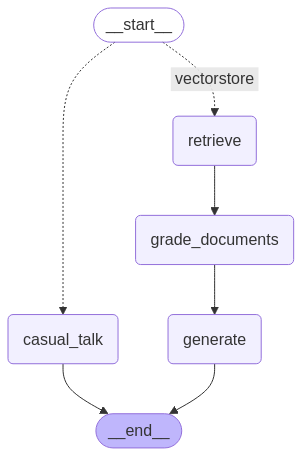

In [41]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    #  실패 시 통과
    pass


In [43]:
inputs = {
    "question": "서울시 쓰레기 저감 계획"
}

app.invoke(inputs) # workflow를 실행합니다.

------ROUTE------
---Routing to vectorstore---
------RETRIEVE------
------GRADE------
------GENERATE------


{'question': '서울시 쓰레기 저감 계획',
 'generation': AIMessage(content='서울시의 쓰레기 저감 계획은 2027년까지 인구당 생활폐기물 발생량을 0.86㎏/인/일로 설정하고 있습니다. 이는 서울 시민이 하루 평균 배출하는 생활폐기물의 양을 줄이기 위한 목표입니다. 이와 함께 생활폐기물 중 매립되는 비율도 감소시킬 계획입니다. 서울시는 자원 순환을 촉진하고, 생활폐기물 처리 방식의 개선을 통해 환경 부담을 줄이는 노력을 지속하고 있습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 117, 'prompt_tokens': 776, 'total_tokens': 893, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'id': 'chatcmpl-BDuCfV580RO46pOMg8UNYcGDP8ioe', 'finish_reason': 'stop', 'logprobs': None}, id='run-a74f7dd2-aa88-4784-9730-317e176fbbfb-0', usage_metadata={'input_tokens': 776, 'output_tokens': 117, 'total_tokens': 893, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'au

In [44]:
inputs = {
    "question": "잘 지내고 있어?"
}

app.invoke(inputs) # workflow를 실행합니다.

------ROUTE------
---Routing to casual_talk---
------CASUAL TALK------


{'question': '잘 지내고 있어?',
 'generation': AIMessage(content='네, 잘 지내고 있습니다! 당신은 어떻게 지내고 계신가요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 13, 'total_tokens': 33, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'id': 'chatcmpl-BDuD0qBHiGN24eIUYO3UuEL1z2rmZ', 'finish_reason': 'stop', 'logprobs': None}, id='run-5ee35a36-f83e-423b-b16f-a794b907fc96-0', usage_metadata={'input_tokens': 13, 'output_tokens': 20, 'total_tokens': 33, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}

### 스트림 출력도 가능하다. 

In [46]:
inputs = {
    "question": "서울시의 자전거 도로 관련 계획은 무엇이 있나요?"
}

for msg, meta in app.stream(inputs, stream_mode='messages'):
    print(msg.content, end='')


------ROUTE------
{"datasource":"vectorstore"}---Routing to vectorstore---
------RETRIEVE------
------GRADE------
{"binary_score":"yes"}{"binary_score":"yes"}{"binary_score":"yes"}{"binary_score":"no"}{"binary_score":"no"}------GENERATE------
서울시의 자전거 도로 관련 계획은 다음과 같습니다:

1. **친환경 교통수단 중심의 도로 정비**: 서울시는 개인 이동 수단(PM) 및 자전거와 같은 친환경 교통수단을 중심으로 지상 도로를 정비하고 있습니다. 이를 통해 자전거 간선도로(CRT)를 확대 설치하며, 보행환경개선지구를 지정하고 사업을 추진하여 사람 중심의 교통체계를 개선하기 위한 노력을 하고 있습니다.

2. **교통체계 재정비**: 자전거의 역할을 생활교통 수단으로 정립하고, 권역별로 단절 없는 자전거 도로를 구축하여 교통체계를 재정비하는 계획이 포함되어 있습니다. 이를 통해 보행활동이 중심이 되는 대중교통과 근린 모빌리티(자전거 포함)를 연결하는 보행·대중교통 통합형 네트워크를 구축할 예정입니다.

3. **기타 교통망과의 연계**: 다양한 이동수단에 대한 역할을 정립하고, 광역철도 및 자율주행 공유수단과 함께 자전거와 PM을 활용하여 지역과 주요 거점 간의 연결성을 높이는 방안도 검토되고 있습니다.

이와 같은 계획들은 서울의 교통체계를 보다 친환경적이고 효율적으로 변화시키기 위한전반적인 전략의 일환으로 시행되고 있습니다.